In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import lmfit

In [2]:
loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Measurements\lamp_test.hdf5'
timestamp = []
intensity = []
with h5py.File(loc) as file:
    group = file['2023-11-08_lamp_stability']['uv-vis']
    wavelength = group.attrs['wavelength']
    background = group.attrs['background']
    for key in group.keys():
        timestamp.append(group[key].attrs['time_ms'])
        intensity.append(group[key][()]) 

intensity = np.array(intensity)
timestamp = np.array(timestamp)

In [3]:
arg_sort = np.argsort(timestamp)
intensity_sorted = intensity[arg_sort]
timestamp_sorted = timestamp[arg_sort]

mask = (wavelength > 200) & (wavelength < 600)
wav_mask = wavelength[mask]
inten_mask = intensity_sorted[:, mask]

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n_average = 25
averaged_timestamps = moving_average(timestamp_sorted-timestamp_sorted[0], n_average)/60_000
averaged_intensity = moving_average(inten_mask, n_average)
averaged_intensity = averaged_intensity/averaged_intensity[-1]

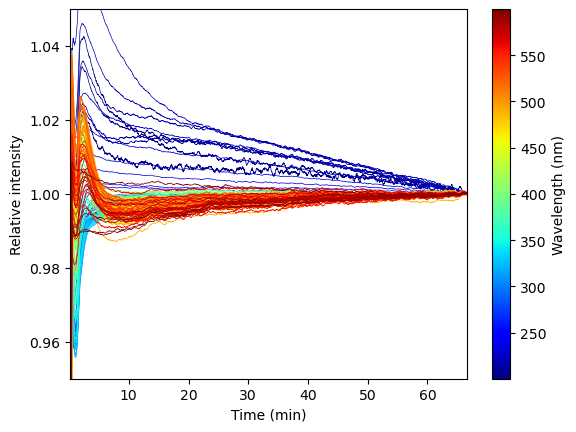

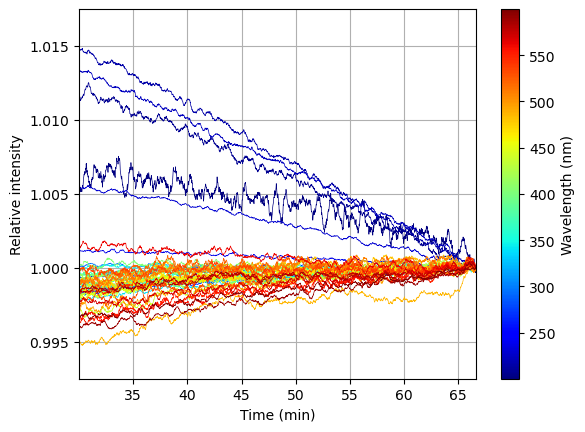

In [4]:
jet = plt.get_cmap('jet')
every = 10

plt.figure()
for wav, inten in zip(wav_mask[::every], averaged_intensity.T[::every]):
    plt.plot(averaged_timestamps, inten,
             c=jet((wav-wav_mask[0])/(wav_mask[-1]-wav_mask[0])), linewidth=0.5)
sm = plt.cm.ScalarMappable(cmap=jet, norm=plt.Normalize(vmin=wav_mask[0], vmax=wav_mask[-1]))
plt.colorbar(sm, label='Wavelength (nm)', ax=plt.gca())
plt.xlim(averaged_timestamps[0], averaged_timestamps[-1])
plt.ylim(0.95, 1.05)
plt.xlabel('Time (min)')
plt.ylabel('Relative intensity')
plt.show()

every = 25
index = np.searchsorted(averaged_timestamps, 30)
plt.figure()
for wav, inten in zip(wav_mask[::every], averaged_intensity.T[::every]):
    plt.plot(averaged_timestamps[index:], inten[index:],
             c=jet((wav-wav_mask[0])/(wav_mask[-1]-wav_mask[0])), linewidth=0.5)
sm = plt.cm.ScalarMappable(cmap=jet, norm=plt.Normalize(vmin=wav_mask[0], vmax=wav_mask[-1]))
plt.colorbar(sm, label='Wavelength (nm)', ax=plt.gca())
plt.xlim(averaged_timestamps[index:][0], averaged_timestamps[index:][-1])
plt.ylim(0.9925, 1.0175)
plt.xlabel('Time (min)')
plt.ylabel('Relative intensity')
plt.grid()
plt.show()

In [5]:
index = np.searchsorted(averaged_timestamps, 50)
intensity_selected = intensity_sorted[index:]
lin_model = lmfit.models.LinearModel()

slopes = []
slopes_std = []

for wav in intensity_selected.T:
    result = lin_model.fit(wav, x=np.arange(len(wav)))
    slopes.append(result.params['slope'].value)
    slopes_std.append(result.params['slope'].stderr)

slopes = np.array(slopes)
slopes_std = np.array(slopes_std)

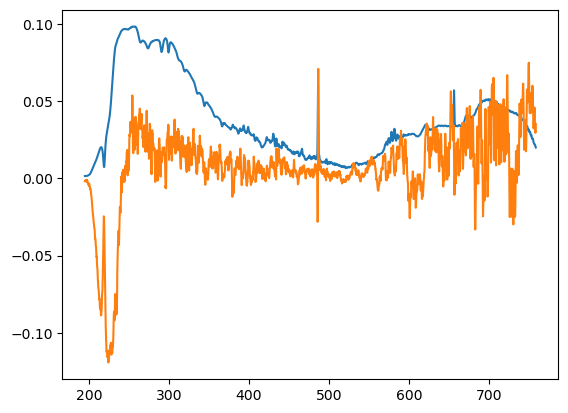

In [6]:
every = 1
plt.figure()
plt.plot(wavelength, intensity_sorted[-1]/600_000)
plt.plot(wavelength[::every], slopes[::every], '-')
plt.show()